In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
from sklearn.linear_model import Lasso
import math
import matplotlib.patches as patches

In [2]:
params = { 'figure.figsize': (12.,4.),
          'axes.labelsize': 18,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15,
          'legend.fontsize': 15 }
plt.rcParams.update(params)

In [3]:
colors = ["#009DD9", "#E37321", "#ECB020", "#D93C00"]

In [4]:
def rulkov_map(x,beta, mu, sigma):
    x = x.reshape(n,m).T
    return np.asarray([
        beta/(1+x[0]**2)+x[1],
        x[1]-mu*x[0]-sigma
        ]).T.flatten()

In [5]:
time = 10000
transient = 30000
mu=0.001; sigma=0.001; beta=4.1;

In [6]:
n = 1
m = 2 #dimension

In [7]:
# initial conditions for Rulkov map
#np.random.seed(1)
x=np.zeros([2,n,time])
x[0,:,0] = np.random.uniform(0.0,1.0,n)
x[1,:,0] = np.random.uniform(0.0,1.0,n)
x0 = np.vstack((x[0,:,0],x[1,:,0])).flatten()

In [8]:
%%time
# transient for the isolated dynamics
for l in range(transient):
    x0 = rulkov_map(x0,beta,mu,sigma)

x=np.zeros([m*n,time])

x[:,0] = x0

for l in range(time-1):
    x[:,l+1] = rulkov_map(x[:,l],beta,mu,sigma)

CPU times: user 184 ms, sys: 13.8 ms, total: 198 ms
Wall time: 188 ms


In [9]:
dx = x[:,1:]
X = x[:,:-1]

In [10]:
library_functions = [
    lambda x : x**2,
    lambda x : x**4,
    lambda x : x**6,
    lambda x : x**8,
    lambda x : x**10,
    lambda x : x**12,
    lambda x : x**14,
    lambda x : x**16,
    lambda x : x**18,
    lambda x : x**20   
]

library_function_names = [
    lambda x : x + '^2',
    lambda x : x + '^4',
    lambda x : x + '^6',
    lambda x : x + '^8',
    lambda x : x + '^10',
    lambda x : x + '^12',
    lambda x : x + '^14',
    lambda x : x + '^16',
    lambda x : x + '^18',
    lambda x : x + '^20'  
]

In [11]:
#use new attr. of pysindy to seperate libraries
#lib_even_poly = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
lib_poly = ps.PolynomialLibrary(degree=30, include_bias=False, include_interaction=False)
lib_mono = ps.PolynomialLibrary(degree=1, include_bias=True, include_interaction=False)

In [12]:
lib = ps.GeneralizedLibrary([lib_poly, lib_mono], inputs_per_library=np.array([[0,0],[1,1]]))

/Users/artun/Documents/GitHub/network-reconstruction/.venv/lib/python3.13/site-packages/pysindy/feature_library/generalized_library.py:101: UserWarning: inputs_per_library should no longer be passed as a numpy array
  warn(


In [13]:
%%time
coeff = []

model = ps.SINDy(feature_library=lib, optimizer=Lasso(alpha=0.0001, fit_intercept=False, max_iter=100000), 
                     discrete_time=True)
model.fit(X.T, x_dot=dx.T)
model.print(lhs=["u'", "v'"])
coeff.append(model.coefficients())
coeffs = np.array(coeff[0])

CPU times: user 65 μs, sys: 17 μs, total: 82 μs
Wall time: 87 μs


TypeError: SINDy.fit() missing 1 required positional argument: 't'

In [14]:
def predicted_rulkov(x):
    return -4.112*x[0]**2 -0.013*x[0]**3 + 4.225*x[0]**4 + 0.138*x[0]**5 -4.556*x[0]**6 -0.619*x[0]**7 + 4.549*x[0]**8 + 1.288*x[0]**9 -2.964*x[0]**10 -1.014*x[0]**11 + 0.294*x[0]**12 -0.533*x[0]**13 + 0.970*x[0]**14 + 1.451*x[0]**15 -0.396*x[0]**16 -0.657*x[0]**17 -0.072*x[0]**18 -0.332*x[0]**19 -0.147*x[0]**20 + 0.394*x[0]**21 + 0.261*x[0]**22 -0.100*x[0]**23 -0.122*x[0]**24 -0.011*x[0]**25 + 0.020*x[0]**26 + 0.007*x[0]**27 + 4.100 + 1.000*x[1]
    ,-0.001*x[0]-0.001+1.000*x[1]

In [15]:
predicted_series = np.zeros_like((x))
predicted_series[:,0] = x[:,0]
for t in range(x.shape[1]-1):
    predicted_series[:,t+1] = predicted_rulkov(x[:,t])

In [53]:
patches.Rectangle?

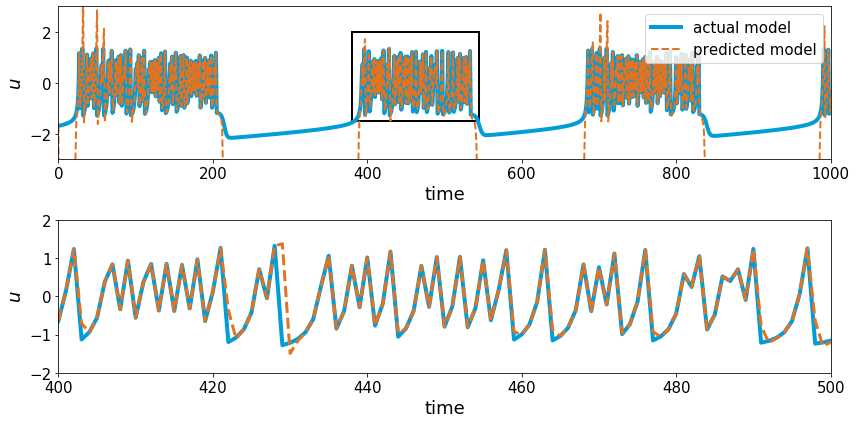

In [85]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(12,6))
axs[0].plot(x[0,:], color=colors[0], label="actual model",alpha=1.0,lw=4)
axs[0].plot(predicted_series[0,:], ls='dashed',lw=2, color=colors[1], label="predicted model", alpha=1)
#current_values = plt.gca().get_yticks()
rect = patches.Rectangle((380, -1.5), 165, 3.5, linewidth=2, edgecolor='k', facecolor='none')
axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.hlines(-1,0,1000)
axs[0].set_ylim(-3,3)
axs[0].set_xlim(0,1000)
axs[0].legend()
axs[0].set_xlabel("time")
axs[0].set_ylabel("$u$")
axs[0].add_patch(rect)
plt.tight_layout()

axs[1].plot(x[0,:], color=colors[0], label="actual model",alpha=1.,lw=4)
axs[1].plot(predicted_series[0,:], ls='dashed', lw=3, color=colors[1], label="predicted model", alpha=1.)
axs[1].set_ylim(-2,2)
axs[1].set_xlim(400,500)
#plt.legend()
axs[1].set_xlabel("time")
axs[1].set_ylabel("$u$")
plt.tight_layout()
plt.savefig("figures/rulkov_model_poly_bases.pdf", format="pdf", transparent=True)

## Add some functions which can be expanded as power series in the library

$e^x = \sum_{n=0}^\infty \frac{x^n}{n!} = 1 + x + \frac{x^2}{2!} + \frac{x^3}{3!} + \cdots $

$\ln{(1-x)} = -\sum_{n=1}^\infty \frac{x^n}{n} = -x - \frac{x^2}{2} - \frac{x^3}{3} - \cdots  $

$\ln{(1+x)} = \sum_{n=1}^\infty (-1)^{n+1} \frac{x^n}{n} = x - \frac{x^2}{2} + \frac{x^3}{3} - \cdots  $

$\sin(x) = \sum_{n=0}^\infty \frac{(-1)^n}{(2n+1)!} x^{2n+1}= x - \frac{x^3}{3!} + \frac{x^5}{5!} + \cdots$

$\cos(x) = \sum_{n=0}^\infty \frac{(-1)^n}{(2n)!} x^{2n}= 1 - \frac{x^2}{2!} + \frac{x^4}{4!} + \cdots$

$\frac{1}{1-x} = \sum_{n=0}^\infty x^n = 1 + x + x^2 + \cdots$

$\frac{1}{1-x^2} = \sum_{n=0}^{\infty} (x^2)^n = 1 + x^2 + x^4 + x^6 + \cdots $

$\frac{1}{(1-x)^2} = \sum_{n=1}^\infty n x^{n-1} = 1 + 2x + 3x^2 + \cdots $

$\frac{1}{1+x} = \frac{1}{1-(-x)} = \sum_{n=0}^\infty (-x)^n = 1 - x + x^2 + \cdots$

$\frac{1}{1+x^2} = \frac{1}{1-(-x^2)} = \sum_{n=0}^{\infty} (-x^2)^n = 1 - x^2 + x^4 - x^6 + x^8 + \cdots $

$\frac{1}{(1+x)^2} = \frac{1}{(1-(-x))^2} = \sum_{n=1}^\infty n(-x)^{n-1} = 1 - 2x + 3x^2 + \cdots$






In [64]:
def f(x):
    return 1/(1+x**2)
def g(x,n):
    y = 0
    for i in range(n):
        y += (-x**2)**i
    return y

In [65]:
a = np.arange(-1.2,1.2,0.01)

In [68]:
y_e = f(a)
y_a = g(a,10)

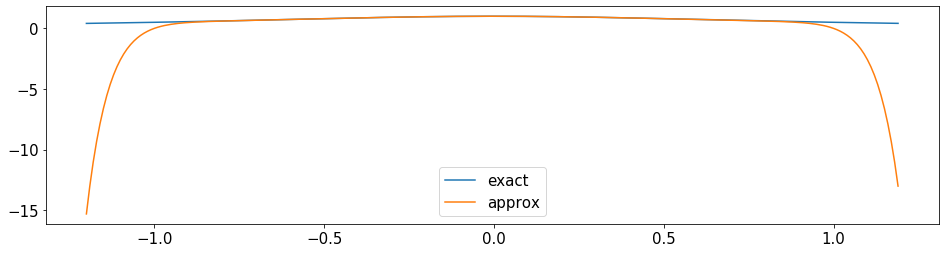

In [69]:
plt.plot(a, y_e, label="exact")
plt.plot(a, y_a, label="approx")
plt.legend()

In [76]:
library_functions = [
    #lambda x : (math.e)**x,
    #lambda x : np.log(1-x),
    #lambda x : np.log(1+x),
    lambda x : np.sin(x),
    lambda x : np.cos(x),
    lambda x : 1/(1-x),
    lambda x : 1/(1-x**2),
    lambda x : 1/((1-x)**2),
    lambda x : 1/(1+x),
    lambda x : 1/(1+x**2),
    lambda x : 1/((1+x)**2),
    lambda x : 1/x,
    lambda x : 1/x**2,
    lambda x : 1/x**3
]

library_function_names = [
    #lambda x : 'e^' + x,
    #lambda x : 'ln(1-'+ x + ')',
    #lambda x : 'ln(1+'+ x + ')',
    lambda x : 'sin(' + x + ')',
    lambda x : 'cos(' + x + ')',
    lambda x : '1/1-' + x,
    lambda x : '1/1-' + x + '^2',
    lambda x : '1/(1-' + x + ')^2',
    lambda x : '1/1+' + x,
    lambda x : '1/1+' + x + '^2',
    lambda x : '1/(1+' + x + ')^2',
    lambda x : '1/' + x,
    lambda x : '1/' + x + '^2',
    lambda x : '1/' + x + '^3'
]

$$
\Psi = \bigg[\bf 1, \big\{ \mathcal{P}(\bf x) \big\}_{i=1}^n, \big\{ \sin(i \bf x) \big\}_{i=1}^n, \big\{ \cos(i \bf x) \big\}_{i=1}^n, \big\{ \tfrac{1}{1 \pm \bf x^i} \big\}_{i=1}^n, \big\{ \tfrac{1}{(1 \pm \bf{x})^i} \big\}_{i=2}^n,
\big\{ \tfrac{1}{\bf{x}^i} \big\}_{i=1}^n \bigg]
$$

In [93]:
#use new attr. of pysindy to seperate libraries
lib_custom = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
lib_poly = ps.PolynomialLibrary(degree=1, include_bias=True, include_interaction=False)

In [94]:
lib = ps.GeneralizedLibrary([lib_custom, lib_poly], inputs_per_library=np.array([[0,1],[0,1]]))

In [100]:
%%time
coeff = []

model = ps.SINDy(feature_library=lib, optimizer=Lasso(alpha=0.0001, fit_intercept=False, max_iter=10000), 
                     discrete_time=True)
model.fit(X.T, x_dot=dx.T)
model.print(lhs=["u'", "v'"])
coeff.append(model.coefficients())
coeffs = np.array(coeff[0])

/Users/irem/miniconda3/envs/network/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.764e+00, tolerance: 2.032e+00
  model = cd_fast.enet_coordinate_descent(


(x0)[k+1] = 4.100 1/1+x0[k]^2 + 1.000 x1[k]
(x1)[k+1] = -0.001 1 + -0.001 x0[k] + 1.000 x1[k]
CPU times: user 3.09 s, sys: 387 ms, total: 3.48 s
Wall time: 1.46 s


In [92]:
%%time
coeff = []

model = ps.SINDy(feature_library=lib, optimizer=Lasso(alpha=0.000559, fit_intercept=False, max_iter=10000), 
                     discrete_time=True)
model.fit(X.T, x_dot=dx.T)
model.print(lhs=["u'", "v'"])
coeff.append(model.coefficients())
coeffs = np.array(coeff[0])

/Users/irem/miniconda3/envs/network/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.800e+01, tolerance: 2.032e+00
  model = cd_fast.enet_coordinate_descent(


(x0)[k+1] = 4.100 1/1+x0[k]^2 + 1.000 x1[k]
(x1)[k+1] = -0.095 sin(x1[k]) + 1.112 x1[k] + 0.001 x0[k]^2 + 0.036 x1[k]^2
CPU times: user 4.53 s, sys: 528 ms, total: 5.06 s
Wall time: 1.82 s


In [96]:
lib.get_feature_names()

['sin(x0)',
 'sin(x1)',
 'cos(x0)',
 'cos(x1)',
 '1/1-x0',
 '1/1-x1',
 '1/1-x0^2',
 '1/1-x1^2',
 '1/(1-x0)^2',
 '1/(1-x1)^2',
 '1/1+x0',
 '1/1+x1',
 '1/1+x0^2',
 '1/1+x1^2',
 '1/(1+x0)^2',
 '1/(1+x1)^2',
 '1/x0',
 '1/x1',
 '1/x0^2',
 '1/x1^2',
 '1/x0^3',
 '1/x1^3',
 '1',
 'x0',
 'x1']

In [84]:
def predicted_rulkov_(x):
    return 4.100/(1+x[0]**2) + 1.000*x[1], -0.001 - 0.001*x[0] + 1.000*x[1]

In [85]:
predicted_series = np.zeros_like((x))
predicted_series[:,0] = x[:,0]
for t in range(x.shape[1]-1):
    predicted_series[:,t+1] = predicted_rulkov_(x[:,t])

Text(0, 0.5, 'u')

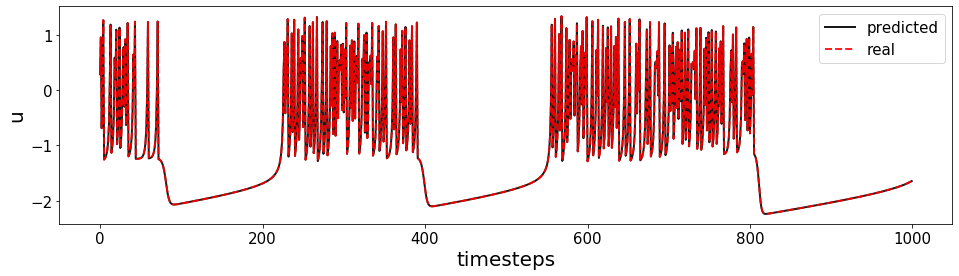

In [89]:
plt.plot(predicted_series[0,:], 'k-', lw=2, label="predicted", alpha=0.9)
plt.plot(x[0,:], 'r--', label="real",alpha=0.9,lw=1.9)
#plt.hlines(-1,0,1000)
#plt.ylim(-2,2)
#plt.xlim(0,1000)
plt.legend()
plt.xlabel("timesteps")
plt.ylabel("u")